If you are running this notebook on Google Colab, the following cell will install the required dependencies and download pre-computed weights from the github repo.

In [1]:
try:
  import google.colab
  IN_COLAB = True

  # Install pgmpy and daft
  !pip install pgmpy==0.1.24 daft==0.1.2
  
  # Download pre-computed weights
  !wget https://raw.githubusercontent.com/vsimkus/pmr2024-pgm-demo/main/heckermans-car-fully-connected-BayesNet.bif
  !wget https://raw.githubusercontent.com/vsimkus/pmr2024-pgm-demo/main/heckermans-car-extended-BayesNet.bif
  !wget https://github.com/vsimkus/pmr2024-pgm-demo/raw/main/heckermans-car-joint-probability-table.npy
except:
  IN_COLAB = False

In [2]:
import itertools
import warnings

import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from IPython.display import Image, display

from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD, JointProbabilityDistribution
from pgmpy.inference import VariableElimination

## Table of contents

* Model (Heckerman's car start model)
    * Joint probability table (JPT)
    * Bayesian network (BN) by chain rule
    * Bayesian network (BN) with conditional independencies
        * Exercise: define the BN
        * Exercise: define the conditional probability tables (CPTs)
* Probabilistic inference on the BN model
    * Exercise: debug the car's failure to start using the BN
    * Exercise: verify "explaining away" phenomenon
* Extended car model
    * Inference on the extended model
        * Exercise: debug the car's failure to start using the extended BN
* (Optional) Convert the original BN to a Markov Network


## Helpers

In this exercise, we will use [pgmpy](https://github.com/pgmpy/pgmpy) Python library, which implements simple [probabilistic graphical models](https://en.wikipedia.org/wiki/Graphical_model) such as Bayesian and Markov networks, learning algorithms, and exact inference methods. We will use it to model a probabilistic system and perform inference tasks on the model.

Before we do so, we define some helper functions that you may use later.

In [3]:
def get_num_necessary_parameters(model):
    """
    Computes the number of _necessary_ parameters in a model.
    
    pgmpy uses one parameter to represent each of the K states, 
    but due to normalisation we only require using K-1
    So let's only count the number of necessary parameters.
    """
    if isinstance(model, BayesianNetwork):
        # Get all conditional probability tables (CPT) in the model
        cpts = model.get_cpds()
        cpts_params = []
        for cpt in cpts:
            # Get params in each of the CPT
            cpt_params = get_num_necessary_parameters(cpt)
            cpts_params.append(cpt_params)
        # Sum over all CPTs
        return sum(cpts_params)
    elif isinstance(model, TabularCPD):
        # Get number of parameters in the CPT
        cpt_params = model.get_values().size
        # Get the cardinality (number of possible states in the CPT)
        K = model.cardinality[0]
        # Recompute the number of necessary parameters
        return int(cpt_params * (1-1/K))
    elif isinstance(model, JointProbabilityDistribution):
        return model.values.size-1
    else:
        raise NotImplementedError(f'Not implemented for {model =}.')

def plot_graph(model):
    """
    Converts the graphical model to PyDot format, and then plots it.
    """
    with warnings.catch_warnings():
        # Ignore some deprecation warnings
        warnings.simplefilter("ignore")

        # Convert the NX graph to PyDot
        pdot = nx.drawing.nx_pydot.to_pydot(model)
        # Create a figure
        pdot_plot = Image(pdot.create_png())
        # Display the figure
        display(pdot_plot)

## Model

In this notebook we illustrate probabilistic graphical modelling (PGM) and inference on a car start Bayesian network [(Heckerman, 1995)](http://tomlr.free.fr/Math%E9matiques/Fichiers%20Claude/Auteurs/AAprov070125/Heckerman%20-%20A%20Tutorial%20On%20Learning%20Bayesian%20Networks.pdf):

![](./figures/heckerman-car-model.png)

This is a simplified model for troubleshooting a car that won't start, where each node represents a variable and directed edges relate causes and effects. For simplicity, we will also assume that each variable is discrete and binary.

In the car start model above we have five variables "Battery", "Fuel", "Gauge", "Turn Over", and "Start". And, each variable has a corresponding (binary) state-space of two possible values (e.g. "good/bad", "empty/not empty", and "yes/no"). So, let us define them below:

In [4]:
# NOTE: avoid using spaces in variable/state names as some features in pgmpy may not work.
variable_states = {
    "Battery":      ["Bad",     "Good"],
    "Fuel":         ["Empty",   "Not_empty"],
    "Gauge":        ["Empty",   "Not_empty"],
    "TurnOver":     ["No",      "Yes"],
    "Start":        ["No",      "Yes"],
}
variables = list(variable_states.keys())
cardinalities = [len(s) for v, s in variable_states.items()]

### Joint probability table (JPT)

One way to model the probability distribution of the car example is using a joint probability table (JPT), which represents the probability for any _joint_ state of the variables.

In [5]:
# Load pre-computed table values
jpt_probabilities = np.load('./heckermans-car-joint-probability-table.npy')

# Create the probability table
jpt = JointProbabilityDistribution(variables, cardinalities, jpt_probabilities)
jpt.store_state_names(variables, cardinalities, variable_states)

print(jpt)

+---------------+-----------------+------------------+---------------+------------+----------------------------------------+
| Battery       | Fuel            | Gauge            | TurnOver      | Start      |   P(Battery,Fuel,Gauge,TurnOver,Start) |
+===============+=================+==================+===============+============+========================================+
| Battery(Bad)  | Fuel(Empty)     | Gauge(Empty)     | TurnOver(No)  | Start(No)  |                                 0.0010 |
+---------------+-----------------+------------------+---------------+------------+----------------------------------------+
| Battery(Bad)  | Fuel(Empty)     | Gauge(Empty)     | TurnOver(No)  | Start(Yes) |                                 0.0000 |
+---------------+-----------------+------------------+---------------+------------+----------------------------------------+
| Battery(Bad)  | Fuel(Empty)     | Gauge(Empty)     | TurnOver(Yes) | Start(No)  |                                 0.0000 |


The number of parameters needed to represent the distribution with a JPT is $K^D-1$, where $D$ is the number of variables and $K$ is the cardinality of each variable.

In our car example $D=5$ and $K=2$, hence the total number of parameters is:

In [6]:
get_num_necessary_parameters(jpt)

31

Using a single JPT to represent distributions is generally inefficient. While our car example only requires a small number of parameters, in general the number of parameters required increases exponentially in the number of variables $D$:

Text(0.5, 0, '# variables')

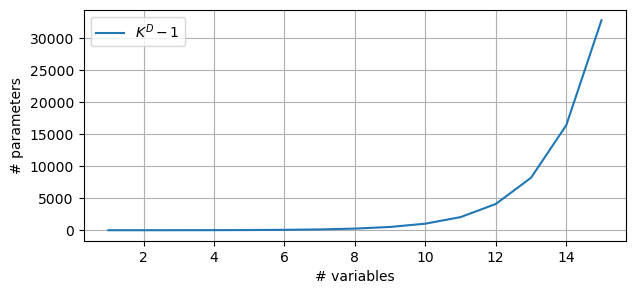

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))

d = np.arange(1, 16)
k = 2
ax.plot(d, k**d -1, label='$K^D-1$')
ax.grid(); ax.legend()
ax.set_ylabel('# parameters')
ax.set_xlabel('# variables')

Even with just $D=15$ binary variables the number of parameters would be $>32000$!

### Baysian network by applying chain rule

Instead of using a single JPT we can apply the chain rule to factorise the joint distribution into conditional factors:
$$p(b, f, g, s, t) = p(b) p(f\mid b) p(g \mid b, f) p(s \mid b, f, g) p(t \mid b, f, g, s).$$

This distribution can then be represented with a fully-connected Bayesian network (BN):

In [8]:
# Create fully-connected DAG edges
edges = [(v1, v2) for j, v1 in enumerate(variables) for v2 in variables[j+1:]]

# Create model and load pre-computed weights
car_model_full = BayesianNetwork(edges).load('./heckermans-car-fully-connected-BayesNet.bif')

We can visualise the DAG of the BN using the helper function `plot_graph()`:

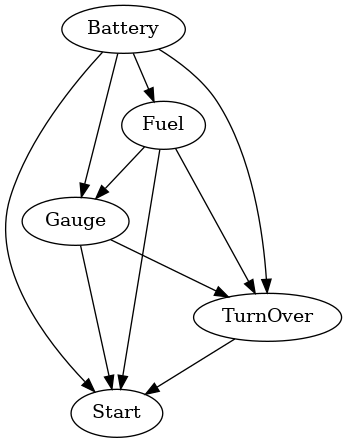

In [9]:
plot_graph(car_model_full)

The DAG of the model is fully connected.

But, instead of representing the distribution using a single JPT, it is now represented using several _conditional_ probability tables (CPTs), one for each (conditional) factor:

In [10]:
# NOTE: the printing function truncates the outputs so that it may fit to screen. The exact values here are not important. 
for cpt in car_model_full.get_cpds():
    if len(cpt.variables) > 1:
        print(f'p( {cpt.variable} | {cpt.variables[1:] })')
    else:
        print(f'p( {cpt.variable} )')
    print(cpt)
    print()

p( Battery )
+---------------+------+
| Battery(Bad)  | 0.02 |
+---------------+------+
| Battery(Good) | 0.98 |
+---------------+------+

p( Fuel | ['Battery'])
+-----------------+--------------+---------------+
| Battery         | Battery(Bad) | Battery(Good) |
+-----------------+--------------+---------------+
| Fuel(Empty)     | 0.05         | 0.05          |
+-----------------+--------------+---------------+
| Fuel(Not_empty) | 0.95         | 0.95          |
+-----------------+--------------+---------------+

p( Gauge | ['Battery', 'Fuel'])
+------------------+--------------+-----+---------------+-----------------+
| Battery          | Battery(Bad) | ... | Battery(Good) | Battery(Good)   |
+------------------+--------------+-----+---------------+-----------------+
| Fuel             | Fuel(Empty)  | ... | Fuel(Empty)   | Fuel(Not_empty) |
+------------------+--------------+-----+---------------+-----------------+
| Gauge(Empty)     | 0.99         | ... | 0.97          | 0.04      

This BN represents the same probability distribution as the joint probability table (JPT) before. So let's verify this by construction the joint distribution from the BN:

In [11]:
# Print the corresponding JPT by infering the probability of all possible variable states
inference = VariableElimination(car_model_full)
q = inference.query(variables=variables)
print(q)

+---------------+-----------------+------------------+---------------+------------+------------------------------------------+
| Battery       | Fuel            | Gauge            | TurnOver      | Start      |   phi(Battery,Fuel,Gauge,TurnOver,Start) |
+===============+=================+==================+===============+============+==========================================+
| Battery(Bad)  | Fuel(Empty)     | Gauge(Empty)     | TurnOver(No)  | Start(No)  |                                   0.0010 |
+---------------+-----------------+------------------+---------------+------------+------------------------------------------+
| Battery(Bad)  | Fuel(Empty)     | Gauge(Empty)     | TurnOver(No)  | Start(Yes) |                                   0.0000 |
+---------------+-----------------+------------------+---------------+------------+------------------------------------------+
| Battery(Bad)  | Fuel(Empty)     | Gauge(Empty)     | TurnOver(Yes) | Start(No)  |                            

Indeed, the Bayesian network represents the same probability distribution as the JPT!

But, as shown above, the DAG is fully connected. So, despite the different representation, the number of parameters in the BN remains the same as in the JPT before:

In [12]:
get_num_necessary_parameters(car_model_full)

31

This is because we have not used the (conditional) independencies provided in the car model! See the DAG below:

![](./figures/heckerman-car-model.png)

To check the (conditional) independencies in the fully connected BN we can use `get_independencies()` method. And, as expected, it shows no independencies.

In [13]:
car_model_full.get_independencies()

### Bayesian network using independencies of the DAG

Let us now represent the car model using an _efficient_ Bayesian network (BN) model that encodes the given indepencies of the car model.

#### [Exercise] Define the Bayesian network

Using the same variable names as before, define the Bayesian network that corresponds to the DAG.

For reference, the variable names are:

In [14]:
variables

['Battery', 'Fuel', 'Gauge', 'TurnOver', 'Start']

**Now, fill in the code.** (The `BayesianNetwork` class takes a list of edges (start$\rightarrow$end) as tuples (start, end).)

In [15]:
car_model = BayesianNetwork(
    [
        #########################
        # Exercise: define tuples of edges in the BayesNet e.g. ("Battery", "TurnOver")
        #########################

        #########################
        
        #########################
        # Solution:
        #########################
        ("Battery", "Gauge"),
        ("Fuel", "Gauge"),
        ("Fuel", "Start"),
        ("TurnOver", "Start"),
        ("Battery", "TurnOver"),
        #########################
    ]
)

 Let us visualise the BN using `plot_graph()`. Verify, if the defined DAG corresponds to the DAG in the Heckerman's car model.

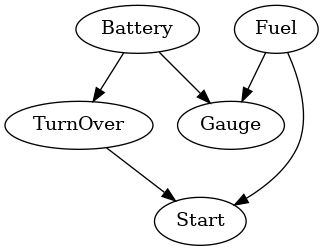

In [16]:
plot_graph(car_model)

#### [Exercise] Define the conditional probability tables (CPTs)

For each factor in the Bayesian network now create the corresponding CPTs. We have provided a helper function `create_cpt()` which creates a CPT given a variable name, evidence/conditioning variable list, and the values of the CPT.

The CPT values should be a 2D list (or numpy array) with the columns summing to 1. (For more information about the format see documentation in <https://pgmpy.org/factors/discrete.html>.) 

Use the probability values from the car model:

![](./figures/heckerman-car-model.png)

**Now fill in the below code.**

In [17]:
def create_cpt(variable, evidence, cpt_values, *, variable_states=variable_states):
    """
    Creates a CPT given a variable name, evidence list, and the CPT value array.
    # NOTE: feel free to change this if needed

    Returns a TabularCPD object, whose arguments are:
    variable_card:              defines the cardinality of the variable
    values:                     correspond to the (conditional) probabilities and columns must sum to 1
    evidence:                   defines the variables in the conditioning set
    evidence_card:              denotes the cardinality of the variables in the conditioning set
    """
    return TabularCPD(
        variable=var, 
        # Use variable cardinality from variable_states variable
        variable_card=len(variable_states[var]), 
        values=cpt_values,
        evidence=evidence,
        # Use evidence variable cardinality from variable_states variable
        evidence_card=[len(variable_states[e]) for e in evidence] if evidence is not None else None,
        state_names=variable_states,
    )

#########################
# Exercise: define 5 CPTs: pt_battery, pt_fuel, cpt_gauge, cpt_turnover, cpt_start
#########################
pt_battery = None

pt_fuel = None

cpt_gauge = None 

cpt_turnover = None

cpt_start = None
#########################

#########################
# Solution:
#########################

var = "Battery"
evidence = None
cpt_values = [[0.02], [0.98]]
pt_battery = create_cpt(var, evidence, cpt_values)

var = "Fuel"
evidence = None
cpt_values = [[0.05], [0.95]]
pt_fuel = create_cpt(var, evidence, cpt_values)

var = "Gauge"
evidence = ["Battery", "Fuel"]
cpt_values = [[0.99, 0.1, 0.97, 0.04], 
              [0.01, 0.9, 0.03, 0.96]]
cpt_gauge = create_cpt(var, evidence, cpt_values)

var = "TurnOver"
evidence = ["Battery"]
cpt_values = [[0.98, 0.03], 
              [0.02, 0.97]]
cpt_turnover = create_cpt(var, evidence, cpt_values)

var = "Start"
evidence = ["TurnOver", "Fuel"]
cpt_values = [[1.0, 1.0, 0.92, 0.01], 
              [0.0, 0.0, 0.08, 0.99]]
cpt_start = create_cpt(var, evidence, cpt_values)

#########################

We are now going to associate the created CPTs with the Bayesian network, and check the validity of the model.

In [18]:
# Associate the parameters with the BN.
car_model.add_cpds(pt_battery, pt_fuel, cpt_gauge, cpt_turnover, cpt_start)

# Checking if the cpts are valid for the model.
car_model.check_model()

True

If the model is valid (i.e. probabilities sum to 1), then the above will print `True`.

So, let us now check if the probability distribution represented by our Bayesian model is the same as the JPT at the beginning of the notebook:

In [19]:
inference = VariableElimination(car_model)
q = inference.query(variables=variables)
print(q)

+---------------+-----------------+------------------+---------------+------------+------------------------------------------+
| Battery       | Fuel            | Gauge            | TurnOver      | Start      |   phi(Battery,Fuel,Gauge,TurnOver,Start) |
+===============+=================+==================+===============+============+==========================================+
| Battery(Bad)  | Fuel(Empty)     | Gauge(Empty)     | TurnOver(No)  | Start(No)  |                                   0.0010 |
+---------------+-----------------+------------------+---------------+------------+------------------------------------------+
| Battery(Bad)  | Fuel(Empty)     | Gauge(Empty)     | TurnOver(No)  | Start(Yes) |                                   0.0000 |
+---------------+-----------------+------------------+---------------+------------+------------------------------------------+
| Battery(Bad)  | Fuel(Empty)     | Gauge(Empty)     | TurnOver(Yes) | Start(No)  |                            

If the model and the CPTs are defined correctly, then the joint probability distribution above will be the same as before.

We can also compare them by running the following cell that will print `True` if they match.

In [20]:
# Compute the JPT from the fully-connected BN
inference = VariableElimination(car_model_full)
q_full = inference.query(variables=variables)

# Compute the JPT from the efficient BN
inference = VariableElimination(car_model)
q = inference.query(variables=variables)

# Compare the JPT values
np.allclose(q.values, q_full.values)

True

Let us now check how many parameters are necessary to represent our model:

In [21]:
get_num_necessary_parameters(car_model)

12

If the model correctly represents the DAG, then the total number of parameters should be 12, just like in the given car model figure!

While 12 is not "much" less than 31, if the number of variables in our model were larger, then this could potentially save a lot of memory. 

Like in our car example, let us assume that each variable has at most two parents. Then, each CPT needs at most $K^2(K-1)$ parameters, and hence in total we need at most $D\cdot K^2(K-1)$ parameters. To illustrate the number of parameters saved we visualise it below:

Text(0.5, 0, '# variables')

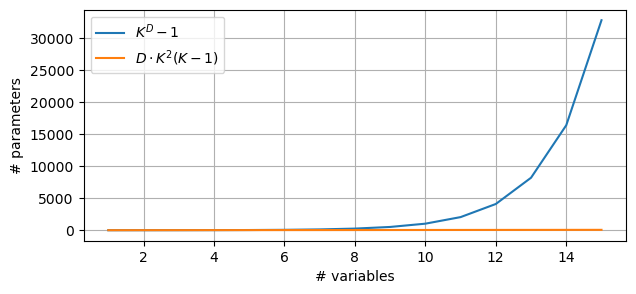

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(7,3))

d = np.arange(1, 16)
k = 2
ax.plot(d, k**d -1, label='$K^D-1$')
ax.plot(d, k**2*(k-1)*d, label='$D \cdot K^2(K-1)$')

ax.grid(); ax.legend()
ax.set_ylabel('# parameters')
ax.set_xlabel('# variables')

Clearly, using the (conditional) independence assumptions allows us to define substantially more memory and computationally efficient models, which is crucial for scaling to systems with many variables.

This is possible because our model now encodes (and uses) the independencies of the DAG:

In [23]:
car_model.get_independencies()

(Start ⟂ Battery | TurnOver)
(Start ⟂ Gauge, Battery | TurnOver, Fuel)
(Start ⟂ Gauge | Fuel, Battery)
(Start ⟂ Battery | TurnOver, Gauge, Fuel)
(Start ⟂ Gauge | Fuel, TurnOver, Battery)
(TurnOver ⟂ Fuel)
(TurnOver ⟂ Gauge, Fuel | Battery)
(TurnOver ⟂ Fuel | Gauge, Battery)
(TurnOver ⟂ Gauge | Fuel, Battery)
(TurnOver ⟂ Gauge | Fuel, Start, Battery)
(Gauge ⟂ TurnOver | Battery)
(Gauge ⟂ Start | TurnOver, Fuel)
(Gauge ⟂ TurnOver, Start | Battery, Fuel)
(Gauge ⟂ Start | Battery, TurnOver, Fuel)
(Gauge ⟂ TurnOver | Battery, Start, Fuel)
(Fuel ⟂ TurnOver, Battery)
(Fuel ⟂ Battery | TurnOver)
(Fuel ⟂ TurnOver | Battery)
(Fuel ⟂ TurnOver | Gauge, Battery)
(Fuel ⟂ Battery | TurnOver, Start)
(Battery ⟂ Fuel)
(Battery ⟂ Start, Fuel | TurnOver)
(Battery ⟂ Fuel | TurnOver, Start)
(Battery ⟂ Start | TurnOver, Fuel)
(Battery ⟂ Start | TurnOver, Gauge, Fuel)

## Inference

Having defined an efficient BN model `car_model` of our car example, we can now perform inference tasks (or ask queries).

To perform probabilistic queries we will use [variable elimination](https://en.wikipedia.org/wiki/Variable_elimination). This is implemented as [`VariableElimination`](https://pgmpy.org/exact_infer/ve.html) class in pgmpy.

First, let us check how likely is our car going to start at any time, which corresponds to querying the marginal probability of the `Start` variable. To do so, we must marginalise the remaining variables to obtain $p(s)$.

In [24]:
inference = VariableElimination(car_model)

q = inference.query(variables=["Start"], evidence=None)
print(q)

+------------+--------------+
| Start      |   phi(Start) |
+============+==============+
| Start(No)  |       0.1018 |
+------------+--------------+
| Start(Yes) |       0.8982 |
+------------+--------------+


Where $\text{phi}(\text{Start}) = p(\text{Start} \mid \text{evidence})$ in the table above. (Note that in this case the evidence is empty, but in the following cases we will ask you to perform queries with non-empty evidence).

It turns out our car is not very great since it won't start over 10% of the time!

### [Exercise] Debug the car's failure to start using the BN

We now want you to debug the car's failure to start by asking probabilistic queries.

Let us say that the car is not starting, i.e. $s=\text{No}$, **what is the probability that there is an issue with the battery?** That is we want to know $p(b \mid s = \text{No})$.

In [25]:
inference = VariableElimination(car_model)

#########################
# Exercise: define query q that computes p(b | s = No),
#           the evidence variable takes a dictionary of the form {"variable": "state",}
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.query(variables=["Battery"], evidence={"Start": "No"})
#########################

print(q)

+---------------+----------------+
| Battery       |   phi(Battery) |
+===============+================+
| Battery(Bad)  |         0.1928 |
+---------------+----------------+
| Battery(Good) |         0.8072 |
+---------------+----------------+


Given our model, there is a significant chance that the battery is still good. 

So let's ask the model **what is the likely state of the fuel tank, given that the car did not start.**

In [26]:
inference = VariableElimination(car_model)

#########################
# Exercise: define query q
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.query(variables=["Fuel"], evidence={"Start": "No"})
#########################

print(q)

+-----------------+-------------+
| Fuel            |   phi(Fuel) |
+=================+=============+
| Fuel(Empty)     |      0.4539 |
+-----------------+-------------+
| Fuel(Not_empty) |      0.5461 |
+-----------------+-------------+


Given our model, the chance that the fuel tank is empty and the car did not start is almost a coin toss. 

So next, we would also like to know which is more likely at fault: an empty fuel tank or a faulty battery (or, perhaps, both). **Query the model for the joint distribution $p(b, f \mid s = \text{No})$.**

In [27]:
inference = VariableElimination(car_model)

#########################
# Exercise: define query q
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.query(variables=["Battery", "Fuel"], evidence={"Start": "No"})
#########################

print(q)

+---------------+-----------------+---------------------+
| Battery       | Fuel            |   phi(Battery,Fuel) |
+===============+=================+=====================+
| Battery(Bad)  | Fuel(Empty)     |              0.0098 |
+---------------+-----------------+---------------------+
| Battery(Bad)  | Fuel(Not_empty) |              0.1830 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Empty)     |              0.4441 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Not_empty) |              0.3631 |
+---------------+-----------------+---------------------+


In the produced table, the MAP configuration is $b=\text{Good}$ and $f=\text{Empty}$, so we should fuel the car as a first attempt to remedy the situation.

In the example above, we have asked you to compute the full conditional distribution of $p(b, f \mid s = \text{No})$ which we then used to read out the MAP configuration. But, if we were *only* interested in the MAP configuration, then we could use [`map_query()`](https://pgmpy.org/exact_infer/ve.html#pgmpy.inference.ExactInference.VariableElimination.map_query) method instead of the [`query()`](https://pgmpy.org/exact_infer/ve.html#pgmpy.inference.ExactInference.VariableElimination.query) method above to compute the MAP state more efficiently. **Query the model using [`map_query()`](https://pgmpy.org/exact_infer/ve.html#pgmpy.inference.ExactInference.VariableElimination.map_query) instead.**

In [28]:
inference = VariableElimination(car_model)

#########################
# Exercise: define query q
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.map_query(variables=["Battery", "Fuel"], evidence={"Start": "No"}, show_progress=False)
#########################

print(q)

{'Battery': 'Good', 'Fuel': 'Empty'}


### Explaining Away

Moreover, it may seem surprising that, given $s=\text{No}$, the second most probable configuration is $b=\text{Good}, f=\text{Not empty}$, i.e. the battery is OK and car is fueled up even though the car didn't start, whereas the probability that $b=\text{Bad}, f=\text{Empty}$ is less than 1%. This occurs for $𝑏=\text{Good},𝑓=\text{Not Empty}$ because there is a non-zero probability of 0.03 that $t=\text{No}$ given that $b=\text{Good}$ (perhaps there could be damp in the electrical circuit which affects turn-over), and if $t=\text{No}$ then from the CPT $s=\text{No}$ with probability 1.

<!-- Although the probability that $t = \text{No}$ is only 0.03 if $b = \text{Good}$, the fact that $p(s = \text{No} |t = \text{No},f = \text{Not Empty}) = 1.0$ means that there is significant mass in the posterior on $b = \text{Good}, f = \text{Not Empty}$. -->

We therefore observe an example of "explaining away": setting either $b=\text{Bad}$ or $f=\text{Empty}$ sufficiently explains the car start failure. We can check by computing the corresponding CPTs, which will indicate that with high likelihood the other component is fine.

#### [Exercise] Verify the "explaining away" phenomenon

Using a probabilistic query, verify the "explaining away" phenomenon. That is, **check that conditional on $s=\text{No}$ and that either $b = \text{Bad}$ OR $f = \text{Empty}$, it is most likely that the remaining component (either $f$ or $b$) is NOT at fault.**

First write the query for fuel tank:

In [29]:
inference = VariableElimination(car_model)

#########################
# Exercise: define query q
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.query(variables=["Fuel"], evidence={"Start": "No", "Battery": "Bad"})
#########################

print(q)

+-----------------+-------------+
| Fuel            |   phi(Fuel) |
+=================+=============+
| Fuel(Empty)     |      0.0509 |
+-----------------+-------------+
| Fuel(Not_empty) |      0.9491 |
+-----------------+-------------+


Now write the query for battery:

In [30]:
inference = VariableElimination(car_model)

#########################
# Exercise: define query q
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.query(variables=["Battery"], evidence={"Start": "No", "Fuel": "Empty"})
#########################

print(q)

+---------------+----------------+
| Battery       |   phi(Battery) |
+===============+================+
| Battery(Bad)  |         0.0216 |
+---------------+----------------+
| Battery(Good) |         0.9784 |
+---------------+----------------+


If the queries and the model is correct, then given $f=\text{Empty}$ or $b=\text{Bad}$ we should see that the remaining component of the car is most likely fine.

## Extended model

Let us now consider an extended model, where we attempt to start the car up to three times before making conclusions about the state of the components.

We show the model below, where each attempt to start the car has its own "Turn Over" and "Start" variables. We also assume that if the car has started in any of the previous attempts, then it will remain started in the following start attempts.

![](./figures/heckerman-car-model-extended.png)

We re-define the extended model variables and their states below, and load the pre-defined model.

In [31]:
variable_states_extended = {
    "Battery":      ["Bad",     "Good"],
    "Fuel":         ["Empty",   "Not_empty"],
    "Gauge":        ["Empty",   "Not_empty"],
    "TurnOver1":    ["No",      "Yes"],
    "TurnOver2":    ["No",      "Yes"],
    "TurnOver3":    ["No",      "Yes"],
    "Start1":       ["No",      "Yes"],
    "Start2":       ["No",      "Yes"],
    "Start3":       ["No",      "Yes"],
}
variables_extended = list(variable_states_extended.keys())
cardinalities_extended = [len(s) for v, s in variable_states_extended.items()]

car_model_extended = BayesianNetwork.load('./heckermans-car-extended-BayesNet.bif')

We now visualise the BN using `plot_graph()` and verify that its DAG corresponds to that of the extended model above. 

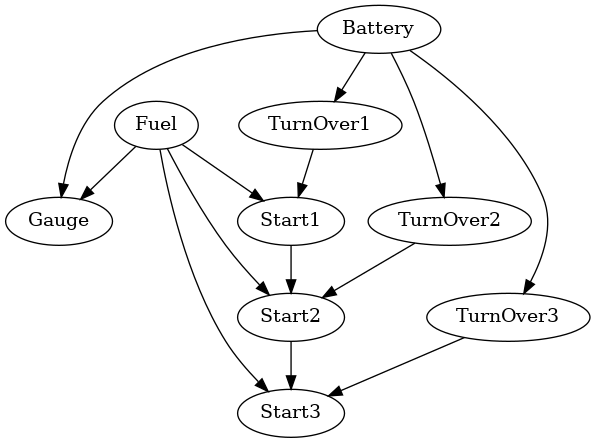

In [32]:
plot_graph(car_model_extended)

Check the validity of the model:

In [33]:
# Checking if the cpts are valid for the model.
car_model_extended.check_model()

True

If the model is valid (i.e. probabilities sum to 1), then the above will print `True`.

Note, while specifying the distribution using a single JPT would require $K^D-1 = 2^9-1 = 511$ parameters, our BN can be specifed using only 32 parameters:

In [34]:
get_num_necessary_parameters(car_model_extended)

32

This highlights the importance of independence assumptions in model specification.

### [Exercise] Debug the car's failure to start using the extended BN model

Let us first verify that the inferences on the extended BN model remain the same as on the original. **Write a query that computes the distribution $p(b, f \mid s1=\text{No})$.**

In [35]:
inference = VariableElimination(car_model_extended)

#########################
# Exercise: define query q that computes p(b, f| s1 = No)
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.query(variables=["Battery", "Fuel"], evidence={"Start1": "No"})
#########################

print(q)

+---------------+-----------------+---------------------+
| Battery       | Fuel            |   phi(Battery,Fuel) |
+===============+=================+=====================+
| Battery(Bad)  | Fuel(Empty)     |              0.0098 |
+---------------+-----------------+---------------------+
| Battery(Bad)  | Fuel(Not_empty) |              0.1830 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Empty)     |              0.4441 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Not_empty) |              0.3631 |
+---------------+-----------------+---------------------+


The computed CPT should be the same as on the original BN model, since the additional variables $t2, s2$ and $t3, s3$ can be marginalised out.

Now, consider the case where the car didn't start on the first turn but started on the second (i.e. $s1=\text{No}, s2=\text{Yes}$). **How likely is there anything wrong with the car?** (HINT: compute $p(b, f \mid s1=\text{No}, s2=\text{Yes})$)

In [36]:
inference = VariableElimination(car_model_extended)

#########################
# Exercise: define query q that computes p(b, f | s1 = No, s2 = Yes)
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.query(variables=["Battery", "Fuel"], evidence={"Start1": "No", "Start2": "Yes"})
#########################

print(q)

+---------------+-----------------+---------------------+
| Battery       | Fuel            |   phi(Battery,Fuel) |
+===============+=================+=====================+
| Battery(Bad)  | Fuel(Empty)     |              0.0000 |
+---------------+-----------------+---------------------+
| Battery(Bad)  | Fuel(Not_empty) |              0.0094 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Empty)     |              0.0891 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Not_empty) |              0.9015 |
+---------------+-----------------+---------------------+


The posterior probability $p(b=\text{Good}, f=\text{Not empty} \mid s1 = \text{No}, s2 = \text{Yes})$ should be high (over 0.9). Whereas the previous MAP configuration $b=\text{Good}, f=\text{Empty}$ should be in the second place with a probability less than 0.1. Hence, if the true configuration is $b=\text{Good}, f=\text{Not empty}$, then the failure to start on the first attempt was likely due to the non-zero probability for $t1=\text{No}$ given $b = \text{Good}$, which means that the failure to turn-over caused the car not to start.

Next, assume that the car did not start until the last turn (i.e. $s1=\text{No}, s2=\text{No}, s3=\text{Yes}$). **Compute the joint probability $p(b, f \mid s1=\text{No}, s2=\text{No}, s3=\text{Yes})$.**

In [37]:
inference = VariableElimination(car_model_extended)

#########################
# Exercise: define query q that computes p(b, f | s1 = No, s2 = No, s3 = Yes)
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.query(variables=["Battery", "Fuel"], evidence={"Start1": "No", "Start2": "No", "Start3": "Yes"})
#########################

print(q)

+---------------+-----------------+---------------------+
| Battery       | Fuel            |   phi(Battery,Fuel) |
+===============+=================+=====================+
| Battery(Bad)  | Fuel(Empty)     |              0.0003 |
+---------------+-----------------+---------------------+
| Battery(Bad)  | Fuel(Not_empty) |              0.0722 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Empty)     |              0.6461 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Not_empty) |              0.2814 |
+---------------+-----------------+---------------------+


We now observe that the MAP configuration is $b=\text{Good}, f=\text{Empty}$ with a probability of over 0.6, whereas the previous MAP configuration $b=\text{Good}, f=\text{Not Empty}$ has now the probability of less than 0.3 (compared to the previous >0.9). The failure to start twice before a success is therefore leading us to the view that $f=\text{Empty}$ is the most likely explanation. Moreover, the probability of $b=\text{Bad}, f=\text{Not Empty}$ has also increased significantly from less than 0.01 to greater than 0.07, showing that an increased number of failures to start before a success also increases our belief that the battery may be bad.

Finally, assume that the car did not start on any of the three attempts (i.e. $s1=\text{No}, s2=\text{No}, s3=\text{No}$). **Compute the joint probability $p(b, f \mid s1=\text{No}, s2=\text{No}, s3=\text{No})$**.

In [38]:
inference = VariableElimination(car_model_extended)

#########################
# Exercise: define query q that computes p(b, f | s1 = No, s2 = No, s3 = No)
#########################
q = None
#########################

#########################
# Solution:
#########################
q = inference.query(variables=["Battery", "Fuel"], evidence={"Start1": "No", "Start2": "No", "Start3": "No"})
#########################

print(q)

+---------------+-----------------+---------------------+
| Battery       | Fuel            |   phi(Battery,Fuel) |
+===============+=================+=====================+
| Battery(Bad)  | Fuel(Empty)     |              0.0173 |
+---------------+-----------------+---------------------+
| Battery(Bad)  | Fuel(Not_empty) |              0.3117 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Empty)     |              0.6699 |
+---------------+-----------------+---------------------+
| Battery(Good) | Fuel(Not_empty) |              0.0010 |
+---------------+-----------------+---------------------+


So the MAP configuration is at $b=\text{Good}, f=\text{Empty}$, meaning that the fuel tank might be empty. And, the second-most likely configuration is now $b=\text{Bad}, f=\text{Not empty}$ (instead of $b=\text{Good}, f=\text{Not empty}$ on the original car model), which indicates that it is very likely that one of the components (either the battery or the fuel tank) is at fault.

The extended model therefore shows that gathering more evidence can help us identify issues with the car more accurately. 

## (Optional) Convert to the original BN to Markov Network and compare independencies

This sub-section is **optional** and part of the material (e.g. ["moralisation"](https://en.wikipedia.org/wiki/Moral_graph)) needed to understand it is covered in Tutorial 3. 

In the lectures we have also learnt about undirected models (or Markov networks, MNs), but BNs and MNs are not always capable of encoding the same conditional independencies. 

Let us convert the _original_ BN car model into an MN using `to_markov_model()` method and visualise it using `plot_graph()`:

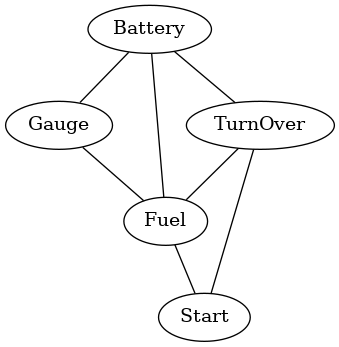

In [39]:
car_model_mn = car_model.to_markov_model()
plot_graph(car_model_mn)

We can see that the BN->MN conversion required "moralisation" of the DAG, which introduced additional edges (see Tutorial 3). **Identify the edges introduced due to "moralisation" and try to understand *why* they got introduced.**

Because of the moralisation, the resulting MN may not contain all independencies of the original BN. To show this, we convert it back to a BN (which is a minimal I-map of the MN) and list the independencies. 

*(Note that the `MarkovNetwork` class in the `pgmpy` package does not have a `get_independencies()` method, so we cannot compare the list of independencies directly. But importantly, a BN->MN conversion preserves as many independencies as can possibly be represented by a MN (without introducing any new independencies), and similarly MN->BN conversion preserves as many independencies as can possibly be represented by a BN. Hence, a BN->MN->BN conversion can be used to show the independencies lost due to the conversion to a MN.)*

In [40]:
# Convert BN->MN->BN and check independencies
car_model_mn.to_bayesian_model().get_independencies()

(Start ⟂ Gauge, Battery | TurnOver, Fuel)
(Start ⟂ Gauge | Battery, Fuel)
(Start ⟂ Battery | Gauge, TurnOver, Fuel)
(Start ⟂ Gauge | Battery, TurnOver, Fuel)
(Gauge ⟂ Start | TurnOver, Fuel)
(Gauge ⟂ TurnOver, Start | Battery, Fuel)
(Gauge ⟂ Start | Battery, TurnOver, Fuel)
(Gauge ⟂ TurnOver | Battery, Start, Fuel)
(TurnOver ⟂ Gauge | Fuel, Battery)
(TurnOver ⟂ Gauge | Fuel, Start, Battery)
(Battery ⟂ Start | TurnOver, Fuel)
(Battery ⟂ Start | TurnOver, Gauge, Fuel)

Clearly, the independence list is reduced because a MN model is not capable of representing some independencies of our BN model. 

Finally, we can also visualise the remaining DAG using `plot_graph()`:

(Note that there is a one-to-many relationship between unnormalised graphs (MNs) and DAGs (BNs), i.e. many different BNs may encode the same independencies as the MN. So the below line might produce a different graph on different runs of the notebook.)

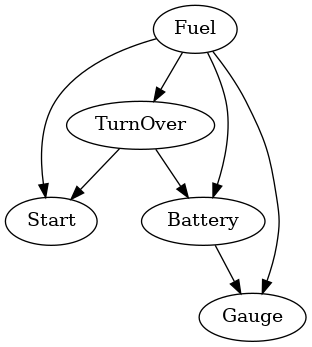

In [41]:
plot_graph(car_model_mn.to_bayesian_model())